In [1]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

from spinapi import *
from PulseBlasterUSB import *
import pyvisa
rm = pyvisa.ResourceManager()
siggen = rm.open_resource('ASRL4::INSTR')
siggen.read_termination = '\r\n'
# siggen.write_termination = '\n'
siggen.baud_rate = 9600
import pandas as pd
from scipy.signal import find_peaks

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nv-group03\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nv-group03\.qcodes\logs\250508-64888-qcodes.log


In [2]:
pulseblaster = PulseBlasterUSB()
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')
microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
lock_in_amp.input_config('I 1M')
microwave_src.IQ_modulation('EXT')
pulseblaster.Stop()
microwave_src.output('OFF')
microwave_src.output_level_unit('dBm')

dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

2025-05-08 16:56:00,368 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ C:\Users\nv-group03\miniconda3\Lib\site-packages\qcodes\instrument\instrument_base.py:183: QCoDeSDeprecationWarning: Parameter ch1_databuffer on instrument lock_in_amp does not correctly pass kwargs to its baseclass. A Parameter class must take `**kwargs` and forward them to its baseclass.
  warnings.warn(

2025-05-08 16:56:00,419 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ C:\Users\nv-group03\miniconda3\Lib\site-packages\qcodes\instrument\instrument_base.py:183: QCoDeSDeprecationWarning: Parameter ch2_databuffer on instrument lock_in_amp does not correctly pass kwargs to its baseclass. A Parameter class must take `**kwargs` and forward them to its baseclass.
  warnings.warn(



Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.32s
Connected to: ANRITSU MG3681A (serial:6100146424, firmware:3.03) in 0.07s
Connected to: KORAD KD3005P V6.7 SN 48562561 (serial:None, firmware:None) in 0.05s


## Review Exercises

### Q1. Review the figures below. For each figure, in words, explain whether you expect the output signal on the lock-in amplifier to be low (i.e. background noise), or high. 

#### Case 1.
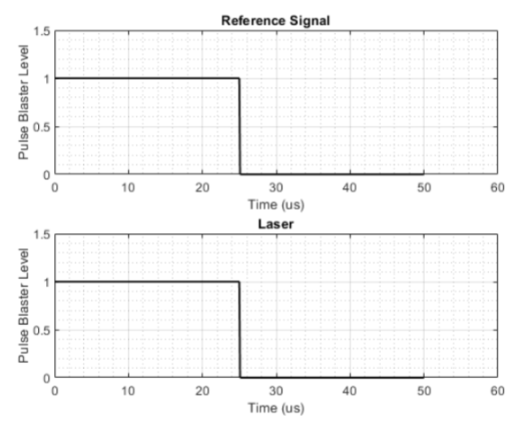

#### Case 2.
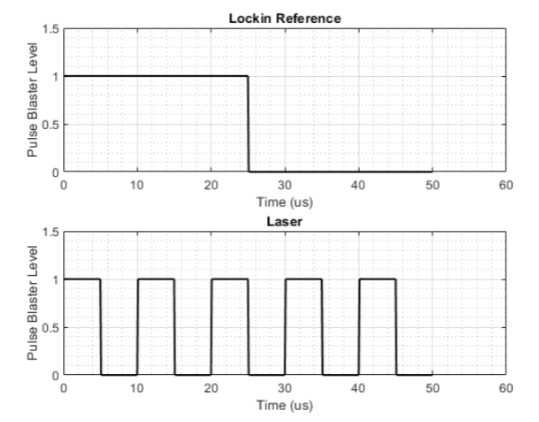

### Q2.  Review the figure below. In words, explain whether you expect the output signal on the lock-in namplifier to be low (i.e. background noise), or high, under each of the following conditions: a) The microwave output is off, b) The microwave output is on at 1 GHz, c) The microwave output is on at 2.87 GHz.

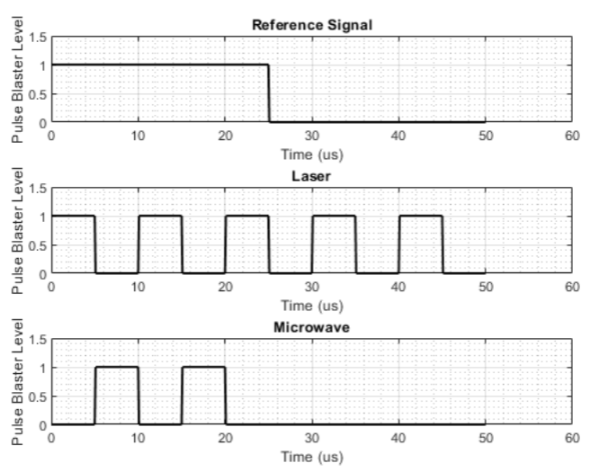

## Optically Detected Magnetic Resonance Magnetometry

In the previous lab, we had performed an experiment to measure the optically detected magnetic resonance at zero magnetic field. In this task, we shall apply a DC magnetic field to the diamond sample and observe what happens to the resonance peaks.

Set the current to 0.5A and observe how this spectrum differs from one with no magnetic field applied.

In [3]:
dc_supply.ch1.voltage_setpoint(5)
dc_supply.ch1.current_setpoint(0.8) #Set to 0.5A

#Use this to make a parameter out of anything!
MW= qc.ManualParameter('Frequency', unit='Hz')
LI_R = qc.ManualParameter('Signal', unit='A')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "ODMR Magnetometry.db")
experiment = load_or_create_experiment(
    experiment_name='ODMR Coil Constant',
    sample_name=""
)

meas = Measurement(exp=experiment, name='ODMR Coil Constant')
meas.register_parameter(MW)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent one

2025-05-08 16:56:00,692 ¦ qcodes.dataset.experiment_container ¦ WARNING ¦ experiment_container ¦ new_experiment ¦ 251 ¦ There is (are) already experiment(s) with the name of ODMR Coil Constant and sample name of some_sample in the database.


250


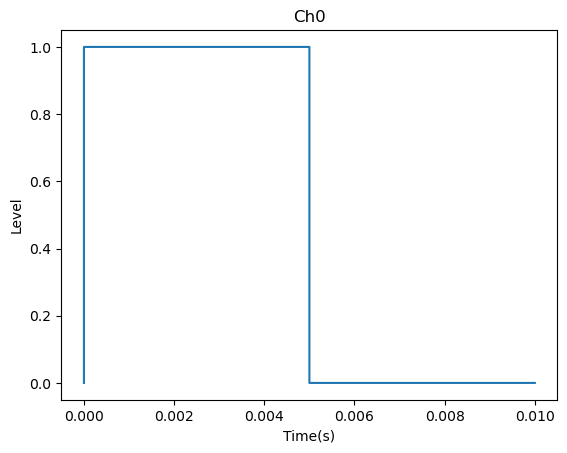

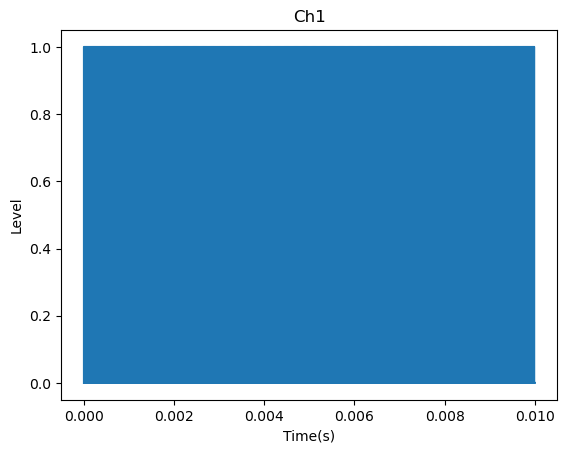

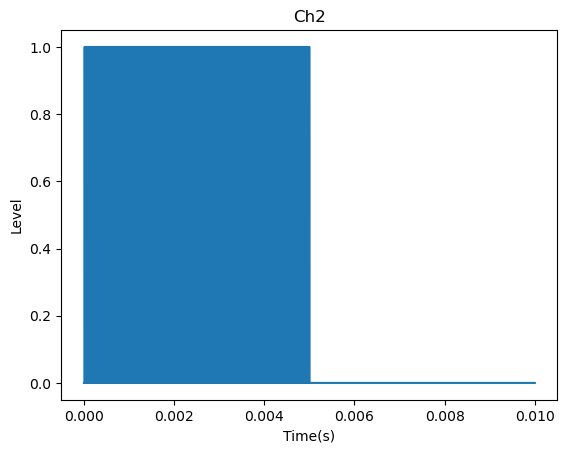

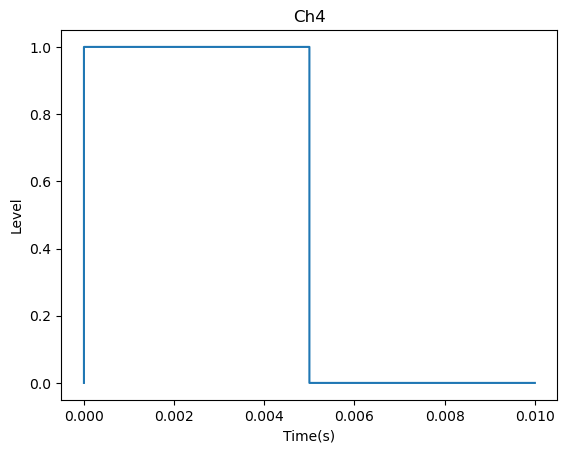

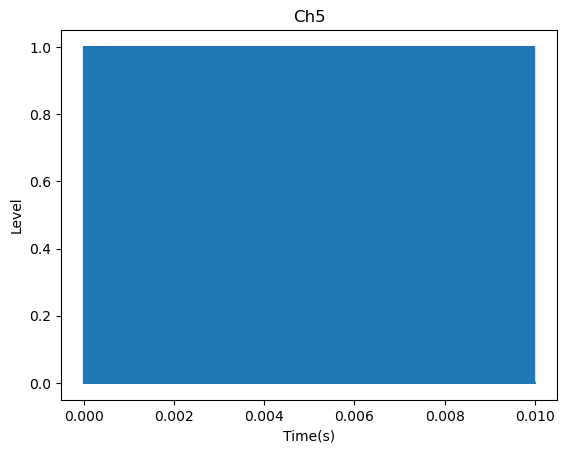

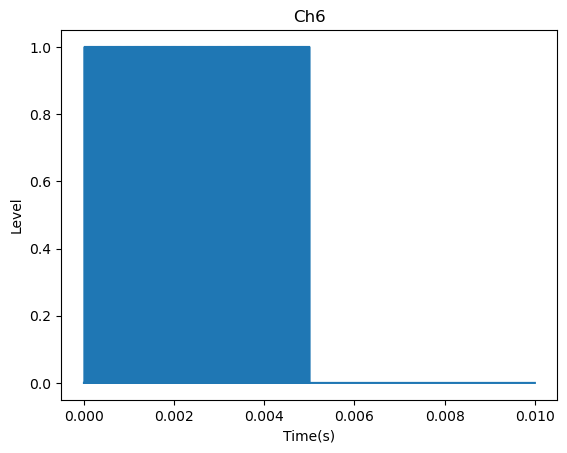

In [4]:
#Your ODMR Code here:
# Parameters
T_reference_on = 5e-3       # 5 ms reference ON
period = 20e-6              # 20 µs period (laser pulse + microwave pulse + padding)
T_laser_on = 5e-6           # Laser ON duration (5 µs)
T_laser_off = period - T_laser_on  # Laser OFF duration
tau_mw = 5e-6               # Microwave pulse duration (5 µs)
tau_padding = 1e-6          # Padding after MW pulse (1 µs)


# Number of laser pulses inside the reference time
N_laser_pulses = int(T_reference_on / period) + 1
print(N_laser_pulses)
def ODMR_sequence(tau_padding, N_laser_pulses):
    channels_on = [0, 1, 2, 4, 5, 6]
    tau_idle = period - tau_mw - tau_padding  # Idle time before MW pulse
    durations_on = [
        [T_reference_on],                             # Channel 0 (Reference ON for full time)
        [T_laser_on, T_laser_off] * N_laser_pulses,    # Channel 1 (Laser flickering)
        [tau_idle, tau_mw, tau_padding] * N_laser_pulses,  # Channel 2 (Microwave pulses)
        [T_reference_on],                             # Channel 4 (Reference monitor)
        [T_laser_on, T_laser_off] * N_laser_pulses,    # Channel 5 (Laser monitor)
        [tau_idle, tau_mw, tau_padding] * N_laser_pulses   # Channel 6 (Microwave monitor)
    ]
    levels_on = [
        [1],                        # Channel 0 ON
        [1, 0] * N_laser_pulses,     # Channel 1 flickering
        [0, 1, 0] * N_laser_pulses,  # Channel 2 (MW pulse centered)
        [1],                        # Channel 4 ON (monitor)
        [1, 0] * N_laser_pulses,     # Channel 5 flickering (monitor)
        [0, 1, 0] * N_laser_pulses   # Channel 6 MW (monitor)
    ]

    # During reference OFF: everything stays OFF
    channels_off = [0, 1, 4, 5]
    durations_off = [
        [T_reference_on],
        [T_laser_on, T_laser_off] * N_laser_pulses,    # Channel 1 (Laser flickering)
        [T_reference_on],
        [T_laser_on, T_laser_off] * N_laser_pulses,    # Channel 1 (Laser flickering)
    ]
    levels_off = [
        [0],  # Channel 0 OFF
        [1, 0] * N_laser_pulses,     # Channel 1 flickering
        [0],  # Channel 4 OFF
        [1, 0] * N_laser_pulses,     # Channel 1 flickering
    ]

    # Build sequences
    temp_on = pulseblaster.get_Instructions(channels_on, durations_on, levels_on, "T")
    temp_off = pulseblaster.get_Instructions(channels_off, durations_off, levels_off, "T")

    odmr_seq_index = pulseblaster.New_Sequence_From_Temp(
        [[temp_on, 1], [temp_off, 1]],  # One cycle of ON and OFF
        "B"
    )

    return odmr_seq_index

# Create and plot the sequence
odmr_seq_index = ODMR_sequence(tau_padding, N_laser_pulses)
pulseblaster.Plot_Sequence(pulseblaster.get_Buffer_Sequence(odmr_seq_index))


In [17]:
pulseblaster.Stop()
microwave_src.output('OFF')
#Set the lock-in amplifier time constant and sensivity using the code segment below.
lock_in_amp.time_constant(100e-3)
lock_in_amp.sensitivity(1e-10) 
#Now we try it with more power.
microwave_src.power() #<= 15dBm

#Write period is the amount of time between start to finish of the experiment.
f_start = 2.7, #start frequency (in Hz)
num_steps = 0.001 #Number of steps
f_end = 3#end frequency. The system will always round up to the nearest step size as to avoid missing a point if this is not divisible evenly. (in seconds)


In [18]:
def Run_ODMR_SEQUENCE(power = -10, f_start = 2.7, f_end = 3, freq_step = 0.01):
    microwave_src.power(power)
    microwave_src.output('ON')
    pulseblaster.Clear_Temp()
    pulseblaster.Clear_Buffer()
    lock_in_amp.send_trigger()
    f_wait = 0 
    f_wait += f_start
    N_step = 0
    while f_wait <= f_end:
        odmr_seq_index = ODMR_sequence(tau_padding, N_laser_pulses)
        f_wait += freq_step
        N_step += 1
    lock_in_amp.R()
    sleep(0.5)
    sweeping_list = np.linspace(f_start, f_end, N_step)
    sweeping_index = 0 
    with meas.run() as datasaver:
        #Your measurement code here
        for index in list(range(0, int((f_end - f_start)/freq_step))): #number of steps = n
            siggen.write('FREQ '+ str(sweeping_list[sweeping_index]) + ' GHz')
            pulseblaster.Run_Buffer_Sequence(odmr_seq_index)
            lock_in_amp.R()
            # sleep(0.5)
            if index == 0:
                sleep(lock_in_amp.time_constant())
            else:
                sleep(lock_in_amp.time_constant())
            X = lock_in_amp.R()
            datasaver.add_result((MW, f_start + index*freq_step),
                                (LI_R, lock_in_amp.R()))
            sweeping_index += 1
        ODMR_data = datasaver.dataset  
    pulseblaster.Stop()
    return ODMR_data


In [19]:
# #Write period is the amount of time between start to finish of the experiment.
# f_start = 2.7 #start frequency (in Hz)
# freq_step = 0.001 #Number of steps
# f_end = 3 #end frequency. The system will always round up to the nearest step size as to avoid missing a point if this is not divisible evenly. (in seconds)
# power = 0 
# # ODMR_data = Run_ODMR_SEQUENCE(power = 0, f_start = f_start, f_end = f_end, freq_step = freq_step)
    
# ODMR = ODMR_data.to_pandas_dataframe()
# ODMR.to_csv("ODMR_with_field.csv")
# plt.plot(ODMR["Frequency"], ODMR["Signal"])
# plt.xlabel('Frequency(Hz)')
# plt.ylabel('Signal(V)')
# plt.title('ODMR')
# plt.show()

## Coil Constant Determination
The coils of the electromagnet are driven by a DC power supply that can be programmed through Matlab. The magnetic field produced by the coils is proportional to the currentpassing through the wires, and so one can easily convert between current and magnetic fieldstrength using a scaling factor. This scaling factor is called the coil constant and usually given in units of Tesla per Ampere [T/A].

In [20]:
#Use this to make a parameter out of anything!
MW= qc.ManualParameter('Frequency', unit='Hz')
Korad = qc.ManualParameter('Current', unit ='A')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "ODMR Current and Frequency Sweep.db")
experiment = load_or_create_experiment(
    experiment_name='ODMR Current and Frequency Sweep',
    sample_name=""
)

meas = Measurement(exp=experiment, name='ODMR Current and Frequency Sweep')
meas.register_parameter(MW)  # register the first independent parameter
meas.register_parameter(Korad)  # register the second independent parameter
meas.register_parameter(LI_R) # now register the dependent one

2025-05-08 17:03:37,777 ¦ qcodes.dataset.experiment_container ¦ WARNING ¦ experiment_container ¦ new_experiment ¦ 251 ¦ There is (are) already experiment(s) with the name of ODMR Current and Frequency Sweep and sample name of some_sample in the database.


In [21]:
def Run_ODMR_Magnetometry(power = -10, f_start = 2.7, f_end = 3, freq_step = 0.01, cur_min = 0, cur_stepsize = 0.08, cur_max = 0.8):
    microwave_src.power(power)
    microwave_src.output('ON')
    pulseblaster.Clear_Temp()
    pulseblaster.Clear_Buffer()
    lock_in_amp.send_trigger()
    f_wait = 0 
    f_wait += f_start
    N_step = 0
    while f_wait <= f_end:
        odmr_seq_index = ODMR_sequence(tau_padding, N_laser_pulses)
        f_wait += freq_step
        N_step += 1
    lock_in_amp.R()
    sleep(0.5)
    sweeping_list = np.linspace(f_start, f_end, N_step)
    sweeping_index = 0 
    with meas.run() as datasaver:
        #Your measurement code here
        for index_1 in list(range(0, int((cur_max - cur_min)/cur_stepsize))): #number of steps = n
            sweeping_index = 0 
            current_currents = cur_min + index_1 * cur_stepsize
            print(current_currents)
            dc_supply.ch1.current_setpoint(current_currents)
            for index_2 in list(range(0, int((f_end - f_start)/freq_step))): #number of steps = n
                siggen.write('FREQ '+ str(sweeping_list[sweeping_index]) + ' GHz')
                pulseblaster.Run_Buffer_Sequence(odmr_seq_index)
                lock_in_amp.R()
                # sleep(0.5)
                sleep(lock_in_amp.time_constant())
                X = lock_in_amp.R()
                datasaver.add_result((MW, f_start + index_2*freq_step),
                                    (Korad, current_currents),
                                    (LI_R, lock_in_amp.R()))
                sweeping_index += 1
        ODMR_data = datasaver.dataset  
    pulseblaster.Stop()
    return ODMR_data


In [10]:
pulseblaster.Stop()
#Set the lock-in amplifier time constant and sensivity using the code segment below.
lock_in_amp.time_constant()
lock_in_amp.sensitivity()
#Now we try it with more power.
microwave_src.power(6)
microwave_src.frequency(2.65e9)
dc_supply.ch1.voltage_setpoint()
dc_supply.ch1.current_setpoint()

#Write period is the amount of time between start to finish of the experiment.

f_start = 2.4e9 #start frequency (in Hz)
num_freq_steps =  100 #Number of steps
f_end = 3e9 #end frequency. The system will always round up to the nearest step size as to avoid missing a point if this is not divisible evenly. (in seconds)
freq_step = (f_end - f_start)/num_freq_steps

cur_min = 0 #Minimum value of the current
cur_stepsize = 0.08 #stepsize
cur_max = 0.8 #Maximum value of the current

In [22]:
#Run the experiment
microwave_src.output('ON')
power = -12
Cur_Freq_Sweep_Data = Run_ODMR_Magnetometry(power = power, f_start = 2.7, f_end = 3, freq_step = 0.0002, cur_min = 0, cur_stepsize = 0.2, cur_max = 0.81).to_pandas_dataframe()

# ax, cbax = plot_dataset(Cur_Freq_Sweep_Data)

Starting experimental run with id: 29. 
0.0
0.2
0.4
0.6000000000000001


In [24]:
Cur_Freq_Sweep_Data.to_csv("ODMR_with_field_0508.csv")

In [25]:
dc_supply.ch1.current_setpoint(0)

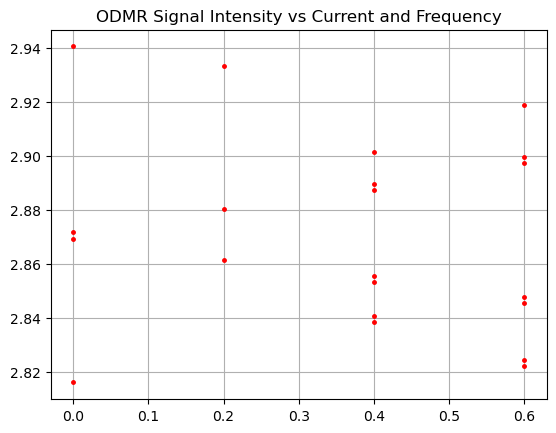

In [26]:
# Extract unique axis values
ODMR_data = Cur_Freq_Sweep_Data
currents = np.sort(ODMR_data["Current"].unique())
frequencies = np.sort(ODMR_data["Frequency"].unique())

# Pivot to 2D array: rows = Frequency, columns = Current
Signal_grid = ODMR_data.pivot(index="Frequency", columns="Current", values="Signal").values

# --- Peak detection along each column (i.e., frequency sweep per current) ---
for col_idx, current in enumerate(currents):
    signal_slice = Signal_grid[:, col_idx]
    peaks, _ = find_peaks(signal_slice, prominence=1e-12)  # adjust as needed
    # Plot peaks as red dots
    peak_freqs = frequencies[peaks]
    plt.plot([current] * len(peak_freqs), peak_freqs, 'r.', markersize=5)

# # Plot the heatmap
# plt.imshow(Signal_grid, aspect='auto', origin='lower',
#            extent=[currents.min(), currents.max(), frequencies.min(), frequencies.max()])
# plt.colorbar(label='Signal Intensity')
# plt.xlabel('Current (A)')
# plt.ylabel('Frequency (GHz)')
plt.title('ODMR Signal Intensity vs Current and Frequency')
plt.grid(True)
plt.show()


4


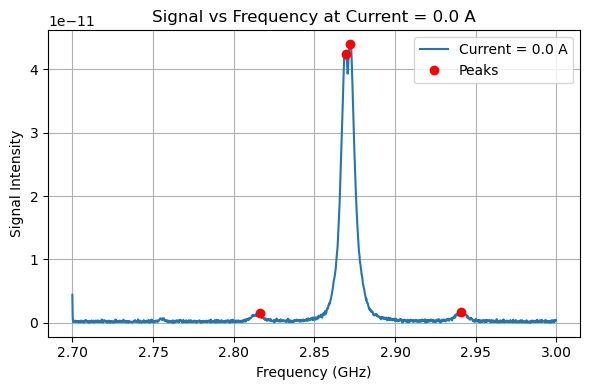

3


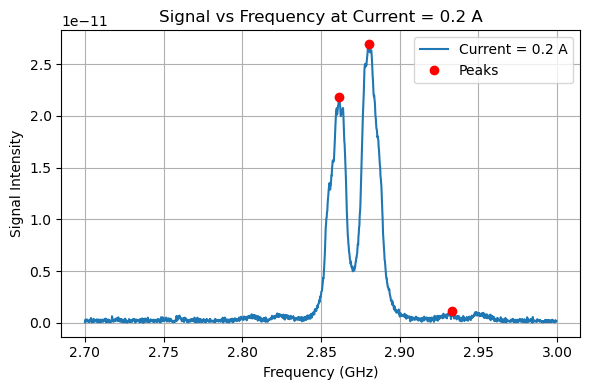

7


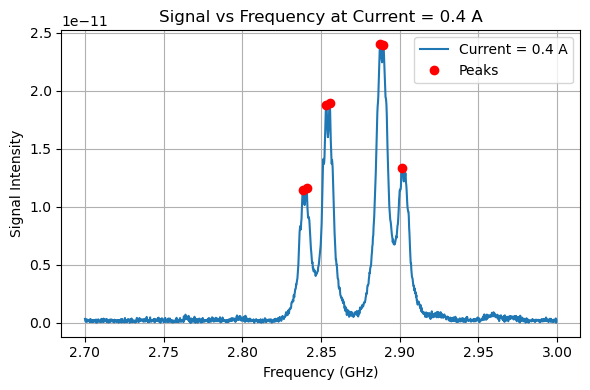

7


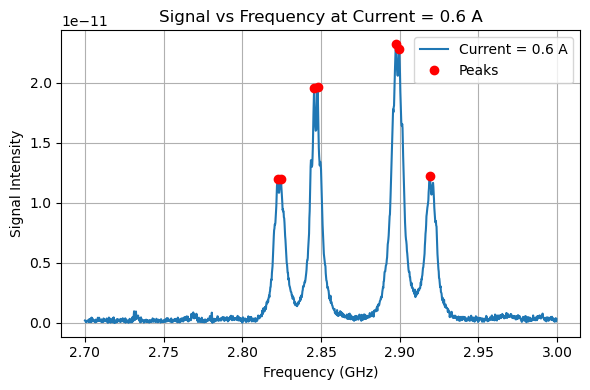

IndexError: index 0 is out of bounds for axis 0 with size 0

In [28]:
# Choose which current values to plot
selected_currents = [0.0, 0.2, 0.4, 0.6, 0.8]  # adjust as needed based on what's in the data

# Plot signal vs frequency for each selected current
for current in selected_currents:
    # if current not in signal_grid.columns:
    #     print(f"Current {current} A not in dataset, skipping.")
    #     continue

    # Find the column index corresponding to the current value
    col_idx = np.where(currents == current)[0][0]
    signal_slice = Signal_grid[:, col_idx]
    peaks, _ = find_peaks(signal_slice, prominence=1e-12)
    print(len(peaks))
    plt.figure(figsize=(6, 4))
    plt.plot(frequencies, signal_slice, label=f'Current = {current} A')
    plt.plot(frequencies[peaks], signal_slice[peaks], 'ro', label='Peaks')
    plt.xlabel('Frequency (GHz)')
    # plt.xlim(2.82,3)
    plt.ylabel('Signal Intensity')
    plt.title(f'Signal vs Frequency at Current = {current} A')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Cur_Freq_ODMR = Cur_Freq_Sweep_Data.to_pandas_dataframe()
#Your code to graph here. See measurement instruction for information on making contour graphs.
print(Cur_Freq_Sweep_Data)
Cur_Freq_Sweep_Data.to_csv("ODMR_with_field.csv")
plt.plot(Cur_Freq_Sweep_Data["Frequency"], Cur_Freq_Sweep_Data["Signal"])
plt.xlabel('Frequency(GHz)')
plt.ylabel('Signal(A)')
plt.title(f'ODMR with field') 
plt.show()

In [ ]:
# Cur_Freq_ODMR = Cur_Freq_Sweep_Data.to_pandas_dataframe()
#Your code to graph here. See measurement instruction for information on making contour graphs.
# list_current = [0:60]


In [ ]:
df = pd.read_csv("ODMR_with_field.csv")
pivoted = df.pivot(index="Current", columns="Frequency", values="Signal")

# Plotting the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pivoted, aspect='auto', origin='lower', 
           extent=[pivoted.columns.min(), pivoted.columns.max(), pivoted.index.min(), pivoted.index.max()])
plt.colorbar(label='Signal')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Current (A)')
plt.title('2D ODMR Heatmap (Signal vs Frequency & Current)')
plt.show()

In [ ]:
print(pivoted)
plt.plot(pivoted["Frequency"][0, 60], pivoted["Signal"][0,60])
plt.xlabel('Frequency(GHz)')
plt.ylabel('Signal(A)')
plt.title(f'ODMR with {power}dbm') 
plt.show()

In [ ]:
# Prepare lists to hold resonance peaks
peak_currents = []
peak_freqs = []
peak_signals = []

# Loop over each current (row)
for current, row in pivoted.iterrows():
    signal = row.values
    freqs = row.index.values

    # In ODMR, resonances are dips → find peaks in -signal
    peaks, _ = find_peaks(signal, prominence=2e-12)  # Adjust prominence as needed

    for peak in peaks:
        peak_currents.append(current)
        peak_freqs.append(freqs[peak])
        peak_signals.append(signal[peak])

# --- Plotting the Heatmap with Peaks Overlay ---
plt.figure(figsize=(10, 6))
plt.imshow(pivoted, aspect='auto', origin='lower',
           extent=[pivoted.columns.min(), pivoted.columns.max(), pivoted.index.min(), pivoted.index.max()])
plt.colorbar(label='Signal')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Current (A)')
plt.title('ODMR Heatmap with Resonance Peaks')

# Overlay the resonance peaks
plt.scatter(peak_freqs, peak_currents, color='red', s=20, label='Resonance Peaks')

plt.legend()
plt.tight_layout()
plt.show()
print(peak_freqs)


### Q3. Carefully note the various salient features of the ODMR spectra. How many resonance peakscan be observed? How many do we expect to see? Do all the resonance peaks react to achange in coil current amplitude in the same way?




## Task 2.2: Simulating ODMR using the NV Hamiltonian

As was pointed out in the first lab and is shown in Fig. 6, The NV center in diamond can be oriented in four unique directions with respect to the crystal axis. Each orientation of the NV center experiences a different effective magnetic field. Thus, the direction of the applied magnetic field may have a significant effect on the ODMR spectra we wish to observe. In this task, we would like to simulate the NV center’s Hamiltonian in order to figure out the orientation of the magnetic field produced by the coils with respect to the sample. 

Before we begine the simulation, we must define:

1. The spin gyromagnetic ratio ('g_e') and zero-field splitting ('D').
2. The spin-1 operators ('S').
3. The primitive vectors of a face-centre cubic lattice ('e').
4. The NV axis vectors ('NV_axis').

In [18]:
g_e = 28e9
D = 2.87e9

S = {'x': [], 'y': [], 'z': []}
S['x'] = np.array([[             0,    1/np.sqrt(2),              0],
                   [  1/np.sqrt(2),               0,   1/np.sqrt(2)],
                   [              0,   1/np.sqrt(2),              0]])

S['y'] = np.array([[              0, -1j/np.sqrt(2),              0],
                   [  1j/np.sqrt(2),              0, -1j/np.sqrt(2)],
                   [              0,  1j/np.sqrt(2),              0]])

S['z'] = np.array([[              1,              0,              0],
                   [              0,              0,              0],
                   [              0,              0,             -1]])

e = {'x': np.array([1, 0, 0]),
     'y': np.array([0, 1, 0]),
     'z': np.array([0, 0, 1])}

NV_axis = np.array([[ 1,  1,  1],
                    [-1, -1,  1],
                    [-1,  1, -1],
                    [ 1, -1, -1]])
NV_axis = [axis / np.linalg.norm(axis) for axis in NV_axis]
NV_comp = {key: [np.dot(axis, e[key]) for axis in NV_axis] for key in e}

For this task adjust the direction of the magnetic field vector ('u') and the coil constant ('coil_constant') (the scaling factor that allows you to convert from current to magnetic field) in the code until the ODMR spectra ‘map’ matches that of the experimental result. Starting values have been provided for you.

In [19]:
coil_constant = 0.01   # in T/A originally 0.012 -> I got 0.01 for my orientation
u = [1.0,.2,0.25]

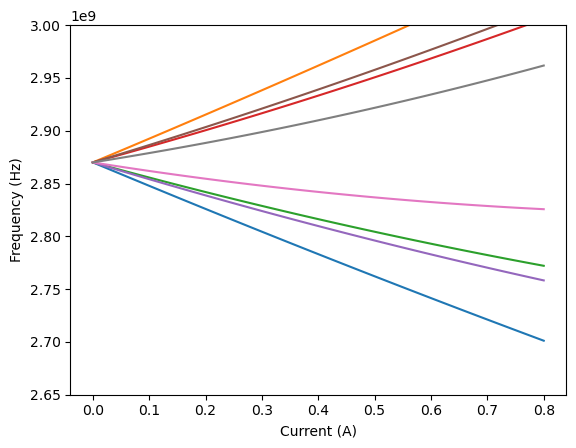

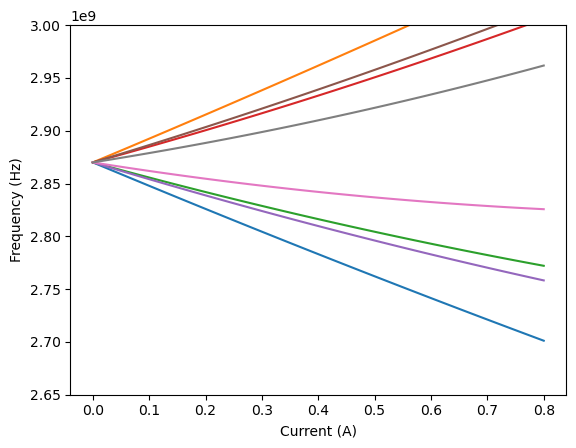

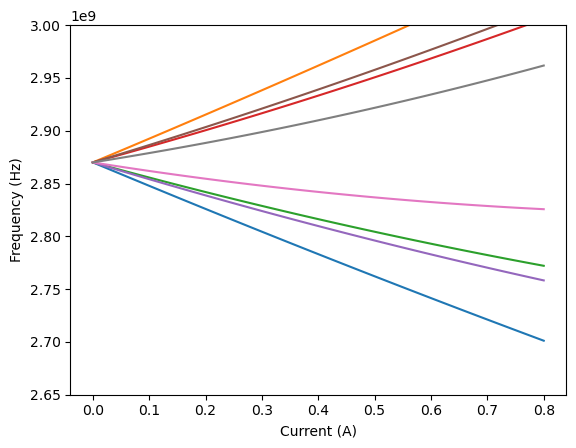

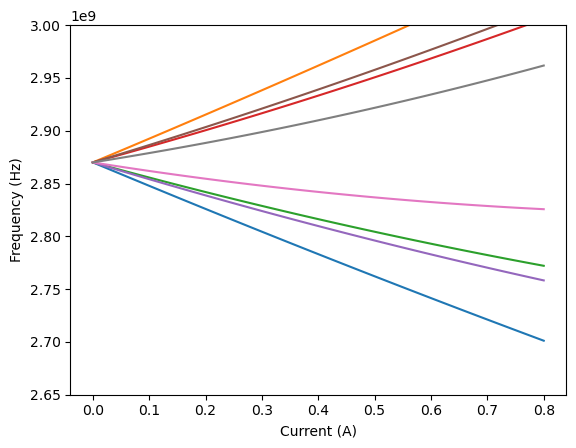

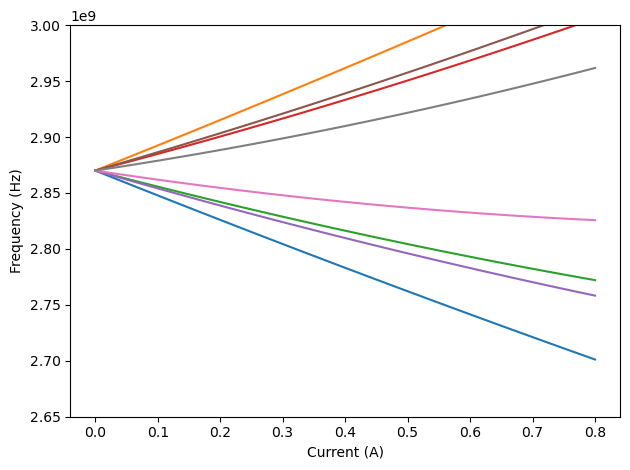

In [24]:
u = np.array(u)
u = u / np.linalg.norm(u)

current = np.linspace(0, 0.8, num=50)
frequency = np.linspace(2.65e9, 3e9, 12)
B0 = coil_constant * current
B = {key: np.dot(u, e[key]) for key in e}

diff_eigs = []
for b0 in B0:
    H=np.ndarray((4, 3, 3), dtype=complex)
    for i in range(0, 4):
        H[i] = D * np.linalg.matrix_power(sum([NV_comp[key][i] * S[key] for key in e]), 2) + \
               g_e * b0 * sum([B[key] * S[key] for key in e])
    eigs = [np.linalg.eig(H[i])[0] for i in range(0, 4)]
    eigs = [np.sort(ev) for ev in eigs]
    diff_eigs.append([[np.real(ev[1]-ev[0]), np.real(ev[2]-ev[0])] for ev in eigs])
diff_eigs = np.array(diff_eigs)

fig, ax = plt.subplots()
data = {}
 

for i in range(0,4):
    for j in range(0,2):
        ax.plot(current, diff_eigs[:, i, j]);
ax.set_ylim([2.65e9, 3e9]);
ax.set_xlabel('Current (A)');
ax.set_ylabel('Frequency (Hz)');
plt.tight_layout()
plt.show()

We now wish to add the data you have measured, to plot above to check whether it agrees with the experiment. Run the code segment below if Task 2.1 has been completed and you wish to use the data just measured. Note this will only work on the lab PC. 

In [11]:
data_ODMR_2D_fit = Cur_Freq_Sweep_Data.to_pandas_dataframe()

NameError: name 'Cur_Freq_Sweep_Data' is not defined